# Image Alignment from Spectral Cubes by Point Selection

The data in this notebook is a set of four simulated IFU cubes from David Law.  The first two dithers (Sequence 1 and 2) are aligned and the second two dithers (Sequence 3 and Sequence 4) are aligned with each other but not with Sequence 1 and 2.

Two steps will happen in here. First, all images are reprojected onto Sequence 1 (using the WCS information stored in the file). Then, the images are aligned using a few different techniques.

All of this is done using a single slice, at this point. 

In [1]:
%matplotlib notebook

from collections import defaultdict

from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from reproject import reproject_interp
from scipy import signal
from scipy.ndimage import interpolation
from image_registration import cross_correlation_shifts, chi2_shifts, register_images


This next class had to be written as ginput does not work in the notebook.  So, it has to listen for mouse clicks via an event handler.  This works, but might be much simpler code if it were stand along python rathern than in Jupyter notebooks

In [2]:
class DisplayGinput(object):
    def __init__(self, images):

        # Internal variables
        self._images = images
        self._pts = defaultdict(list)
        self._image_index = 0
        
        # Show the first image
        self.fig, self.ax = plt.subplots()
        self.text = self.ax.text(0,-25, '')
        self.show_get()
        
        # Set the mouse button callback
        self.cid2 = self.fig.canvas.mpl_connect('button_press_event', self.onclick)

    def show_get(self):
        """
        Show image based on image_index.
        """
        self.ax.imshow(self._images[self._image_index])
    
    def show_text(self, thetext):
        """
        Show the text below the image.
        """
        self.text.set_text(thetext)
    
    def clear_text(self):
        """
        Clear the text.
        """
        self.show_text('')
    
    def onclick(self, event):
        """
        Mouse button click
        """
        
        # Left mouse button
        if event.button == 1:
            self._pts[self._image_index].append((event.xdata, event.ydata))
            self.show_text('Clicked {:.1f}, {:.1f}, Click left button for more, right to got to the next'.format(event.xdata, event.ydata))

        # Right mouse button    
        elif event.button == 3:
            self._image_index = self._image_index + 1
            
        # If we have seen them all, then we are done.
        if self._image_index >= len(self._images):
            self.show_text('You are done, look at the results from reg_images()')
        else:
            self.show_get()
            
    def reg_images(self, interpolate=False):
        """
        Calculate the registered images and return them.
        """
        toreturn = []
        
        # Get target point which is a list of points clicked
        # in the first image
        target_pt = self._pts[0]
        
        # For each image, calculate the amount to roll/shift and then apply it.
        for ii, im in enumerate(self._images):

            # Calculate the average shifts based on all the clicks in each image
            x_shifts, y_shifts = [], []
            for pti, pts in enumerate(self._pts[ii]):
                x_shifts.append(-(pts[1] - target_pt[pti][1]))
                y_shifts.append(-(pts[0] - target_pt[pti][0]))
                
            # This is now the amount we need to shift this image.
            x_shift, y_shift = (np.mean(x_shifts), np.mean(y_shifts))
            
            # Grab the image and set infs and nans to 0.
            im = self._images[ii]
            im[~np.isfinite(im)] = 0
            
            # Use scipy.ndimage.interpolation.shift
            if interpolate:
                roll_pts = (x_shift, y_shift)                
                newim = interpolation.shift(im, roll_pts)

            # Use numpy roll to shift the images by integral amounts.
            else:        
                roll_pts = (int(np.round(x_shift)), int(np.round(y_shift)))
                newim = np.roll(im, roll_pts, axis=(0, 1))
            
            toreturn.append(newim)
                
        return toreturn

Small container class defined just to store some basic info, so things don't have to be repeated.

In [3]:
class IFU(object):

    def __init__(self, filename):
        self.s3d = SpectralCube.read(filename, hdu=1)
        self._slice_number = int(self.s3d.shape[0]//2)
        
        self.spectral_slice = self.s3d[self._slice_number]
        
    def data(self, slice_number):
        spectral_slice = self.s3d[slice_number]
        data = np.array(spectral_slice)
        return data, spectral_slice.wcs

def show(data, title):
    # Display a single image with WCS projection
    pp = np.nanpercentile(data, (1, 99))
    plt.imshow(data, origin='lower', cmap=plt.gray())
    plt.clim(*pp)
    plt.grid(color='white', ls='solid')
    plt.title(title, fontsize=12)

In [4]:
sl = 430

ifu1 = IFU('alldet/det_image_seq1_MIRIFUSHORT_12SHORTexp1_s3d.fits')
ifu2 = IFU('alldet/det_image_seq2_MIRIFUSHORT_12SHORTexp1_s3d.fits')
ifu3 = IFU('alldet/det_image_seq3_MIRIFUSHORT_12SHORTexp1_s3d.fits')
ifu4 = IFU('alldet/det_image_seq4_MIRIFUSHORT_12SHORTexp1_s3d.fits')

/Users/crjones/Documents/DATB/spectralcube/data/incorrect-simulated-mrs/venv/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "


The IFU cubes are loaded up and we are going to display a single slice for each of the sequences. Given the data cubes, we know that Sequence 1 and Sequence 2 should line up.  Sequence 3 and 4 line up with each other but do not line up with Sequence 1 or 2.

This can be seen in the images below as the bright peak is shifted slightly down in the image in Sequence 3 and 4.

<IPython.core.display.Javascript object>


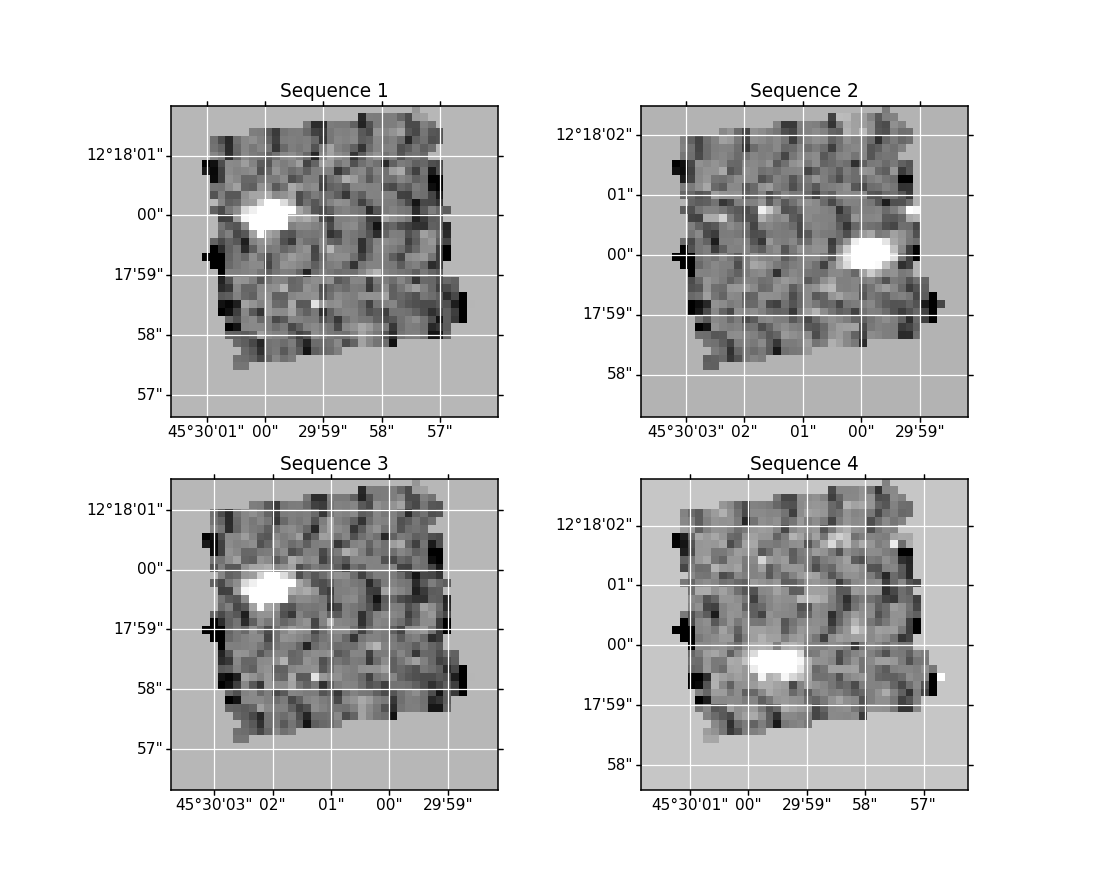

In [5]:
plt.figure(1, figsize=[10,8])

ifu1_data, ifu1_wcs = ifu1.data(sl)
plt.subplot(2,2,1, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

ifu2_data, ifu2_wcs = ifu2.data(sl)
plt.subplot(2,2,2, projection=ifu2_wcs)
show(ifu2_data, 'Sequence 2')

ifu3_data, ifu3_wcs = ifu3.data(sl)
plt.subplot(2,2,3, projection=ifu3_wcs)
show(ifu1_data, 'Sequence 3')

ifu4_data, ifu4_wcs = ifu4.data(sl)
plt.subplot(2,2,4, projection=ifu4_wcs)
show(ifu4_data, 'Sequence 4')


## Reproject onto a Common Grid

The next step will be to reproject them onto a common grid in order to do alignment.  To do the reprojection, the [reproject package](https://github.com/astrofrog/reproject) is used here.

For this, Sequence 2, Sequence 3 and Sequence 4 images will be reprojected onto Sequence 1.  This uses the WCS information used in each of the IFU cubes

In [6]:
ifu1_data, ifu1_wcs = ifu1.data(sl)
ifu2_data, ifu2_wcs = ifu2.data(sl)
ifu3_data, ifu3_wcs = ifu3.data(sl)
ifu4_data, ifu4_wcs = ifu4.data(sl)

ifu1_data_reproj = ifu1_data
ifu2_data_reproj, footprint2 = reproject_interp((ifu2_data, ifu2_wcs), ifu1_wcs, ifu1_data.shape)
ifu3_data_reproj, footprint3 = reproject_interp((ifu3_data, ifu3_wcs), ifu1_wcs, ifu1_data.shape)
ifu4_data_reproj, footprint4 = reproject_interp((ifu4_data, ifu4_wcs), ifu1_wcs, ifu1_data.shape)

<IPython.core.display.Javascript object>


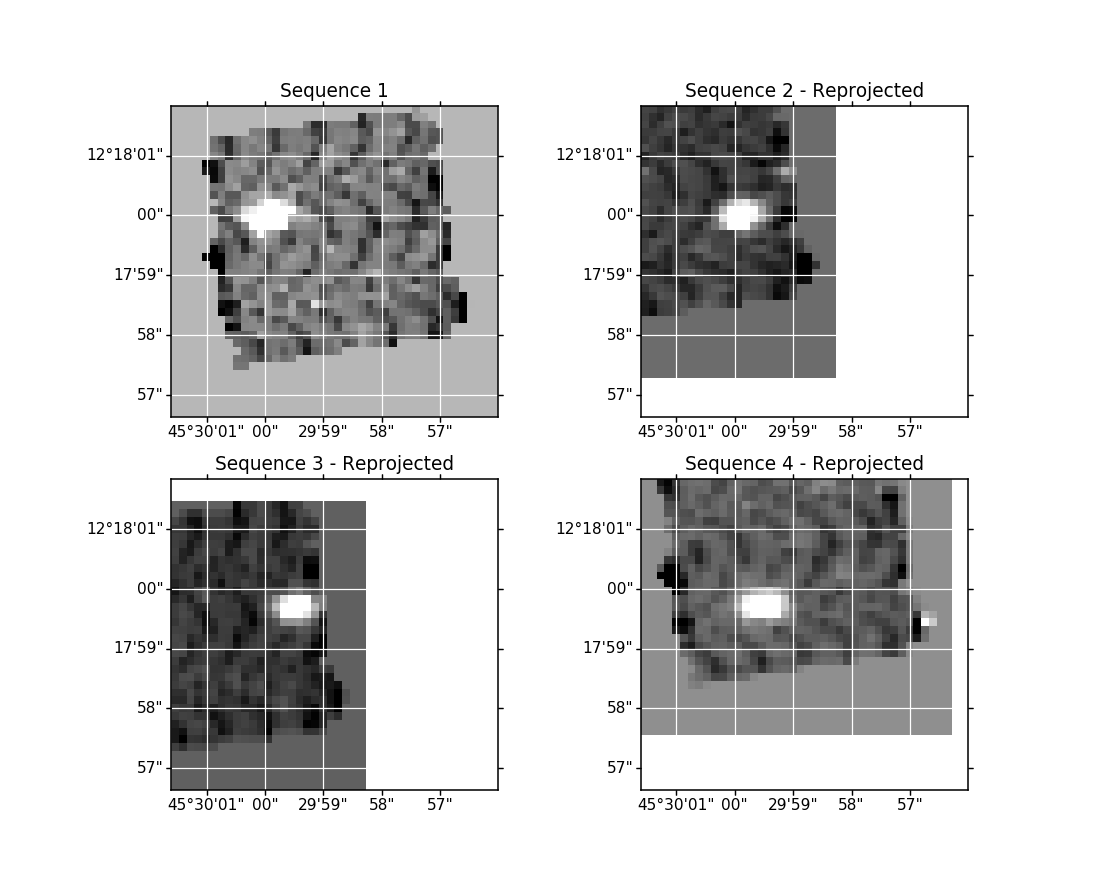

In [7]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj, 'Sequence 2 - Reprojected')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj, 'Sequence 3 - Reprojected')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj, 'Sequence 4 - Reprojected')


So, as expected, Sequence 1 and 2 are still centered at the correct location, but Sequence 3 and 4 are still shifted slightly lower and to the right.  But, at this point, all the images are in the same WCS frame (Sequence 1).

## Alignment

This alignment uses mouse clicks on the image to determine how much to shift images 2 and on in order to map it back to the first image.

There are two methods used in the mapping, one is an image "roll" based on numpy.roll and the second is is an interpoliation based on scipy.ndimage.interplation.shift.

**How to use this**

Click N points in the first image on specific features. Then when done click on the right mouse button.

In the subsequent images, click the **same** features and when done click on the right mouse button.

Once the clicking is done on the last image go to the next notebook cell and run it.

<IPython.core.display.Javascript object>


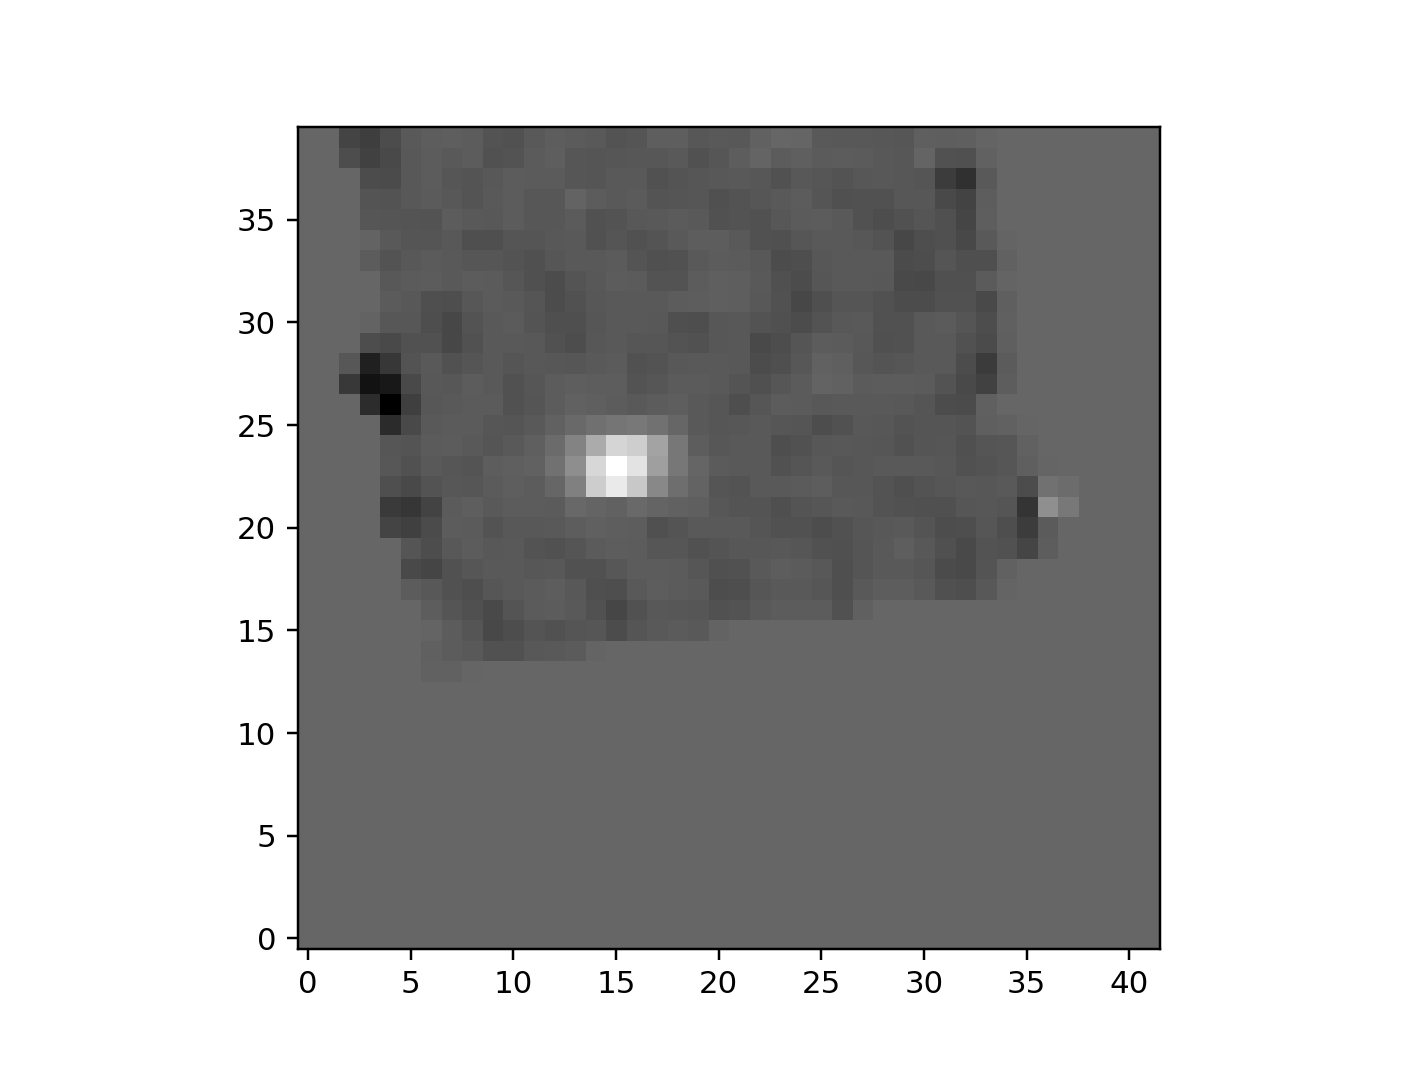

In [11]:
images = [ifu1_data_reproj, ifu2_data_reproj, ifu3_data_reproj, ifu4_data_reproj]
dg = DisplayGinput(images)

## Sum Images from Each Method

And finally, now that we have Sequences 2, 3 and 4 reprojected onto 1 and then aligned using several algorithms in the image-registration package, the sum of the 4 dithers can be calculated using the different methods. The first method is reprojection only and no alignment.

<IPython.core.display.Javascript object>


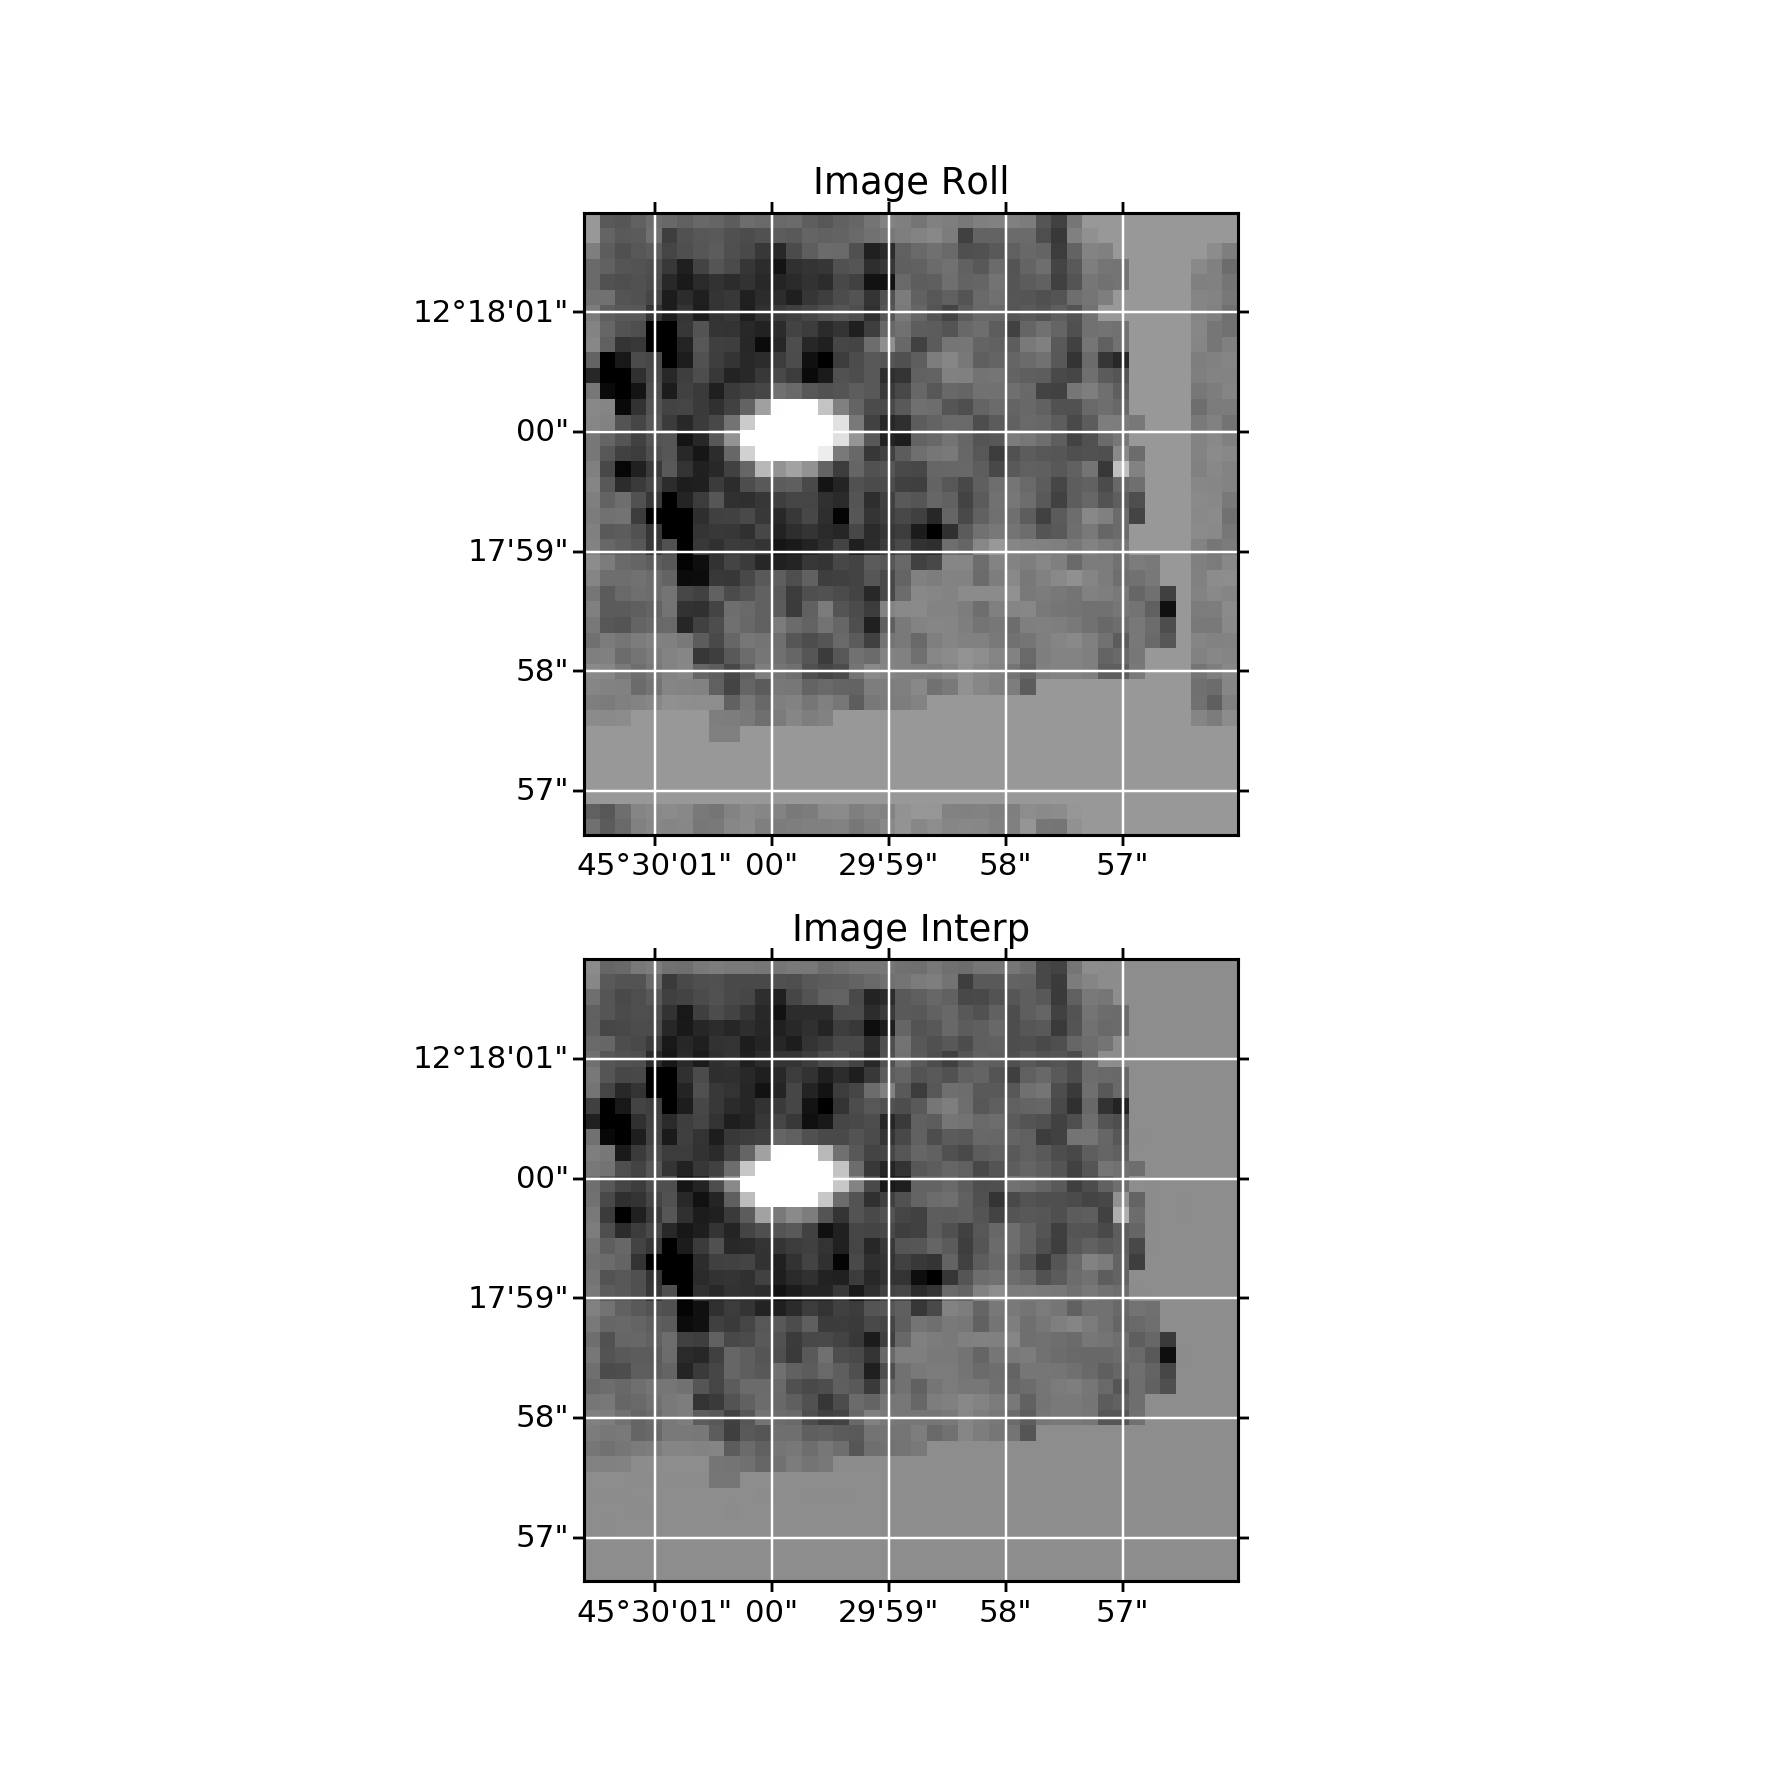

In [13]:
registered_images_roll = dg.reg_images(interpolate=False)
registered_images_interp = dg.reg_images(interpolate=True)

registered_image_roll = np.sum(np.stack(registered_images_roll, axis=-1), axis=2)
registered_image_interp = np.sum(np.stack(registered_images_interp, axis=-1), axis=2)

plt.figure(6,  figsize=[8,8])
plt.clf()
plt.subplot(211, projection=ifu1_wcs)
show(registered_image_roll, 'Image Roll')

plt.subplot(212, projection=ifu1_wcs)
show(registered_image_interp, 'Image Interp')